In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression
import random
import warnings
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
from statsmodels.stats.anova import anova_lm

warnings.filterwarnings("ignore")

/Users/calvinisch/opt/anaconda3/envs/new_project/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/Users/calvinisch/opt/anaconda3/envs/new_project/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Figure 1: Demonstration of harmful/helpful anchors

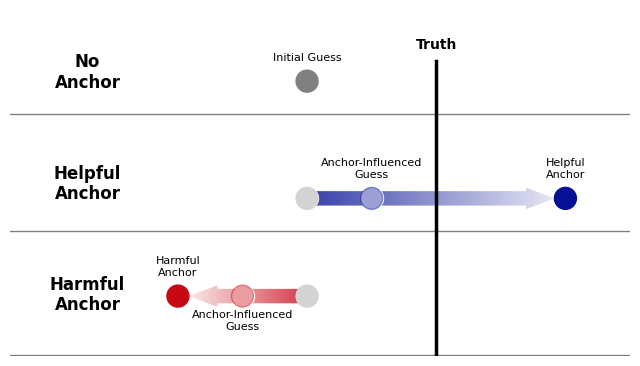

In [2]:
fig, ax = plt.subplots(figsize=(8, 4.5))

colors = ['grey','lightgrey','#051094','#051094','#C80815', '#C80815', 'lightgrey']
values = [200, 200, 250, 400, 100, 150, 200]
ys = [1.165, 1.075,1.075,1.075,1,1,1]
alphas = [1, 1, .4, 1, 1, .4, 1]

# Gradient Arrows
def create_gradient(x_1, x_2, y, n, direction):
    delta_x = (x_2 - x_1) / n   
    for i in range(n):
        if direction:
            alpha_val = .2 + (i/n * .7)
        else:
            alpha_val = .9 - (i/n * .7)
        ax.add_patch(mpatches.Rectangle((x_1+delta_x*i, y), delta_x, .05, fill=True, lw=0, color='w', alpha=alpha_val))
arrow1 = mpatches.FancyArrow(200, 1.075, 190, 0, width=0.01, color='#051094', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
arrow2 = mpatches.FancyArrow(200,1, -90, 0, width=0.01, color='#C80815', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
ax.add_patch(arrow1)
ax.add_patch(arrow2)
create_gradient(200, 390, 1.05, 100, True)
create_gradient(110, 200, .975, 80, False)

scatter = ax.scatter(values, ys, s=250, c='white', marker='o')
scatter = ax.scatter(values, ys, s=250, c=colors, marker='o', alpha = alphas)



labels = ["Initial Guess",
        "Anchor-Influenced\nGuess", 
        "Helpful\nAnchor",
        "Harmful\nAnchor", 
        "Anchor-Influenced\nGuess"]

xs = [200, 250, 400, 100, 150]
ys = [1.165, 1.075,1.075,1,1]
for i, txt in enumerate(labels):
    if i == 4:
        m = -24
    else:
        m = 15
    ax.annotate(txt, (xs[i], ys[i]), textcoords="offset points", xytext=(0,m), ha='center', fontsize=8)

ax.annotate("Truth", (300, 1.19), textcoords="offset points", xytext=(0,0), ha='center', fontsize=10, weight='bold')
ax.annotate("No\nAnchor", (30, 1.16), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12, weight='bold')
ax.annotate("Helpful\nAnchor", (30, 1.08), textcoords="offset points", xytext=(0,-5), ha='center', fontsize=12, weight='bold')
ax.annotate("Harmful\nAnchor", (30, 1), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=12, weight='bold')


ax.axhline(y=1.14, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=1.05, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=0.955, color='gray', linestyle='-', linewidth=1)


ax.set_ylim(0.954, 1.22)
ax.axvline(x=300, ymin = 0, ymax=0.85, color='k', linestyle='-', linewidth=2.5)
ax.set_xlim(-30, 450)
ax.set_xticks([])
ax.get_yaxis().set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('Figures/Figure-1_Types-of-Anchors.png', dpi=300)
plt.show()


# Load data

In [3]:
# Read in data and create composite variables
df = pd.read_csv('ci_cb_2023-06-26.csv')

df['Anchor'] = np.where(df['Condition'] == 'Low', 118, 353)
df['Mag_Rev1'] = abs(df['response_2'] - df['response_1'])
df['Mag_Rev2'] = abs(df['response_3'] - df['response_2'])
df['Mag_Rev'] = abs(df['response_3'] - df['response_1'])
df['Initial_Error'] = abs(df['response_1'] - df['true_answer'])
df['Second_Error'] = abs(df['response_2'] - df['true_answer'])
df['Final_Error'] = abs(df['response_3'] - df['true_answer'])
df['Dist_Anchor_1'] = abs(df['response_1'] - df['Anchor'])
df['Dist_Anchor_2'] = abs(df['response_2'] - df['Anchor'])
df['Dist_Anchor_3'] = abs(df['response_3'] - df['Anchor'])
df['Difference_Initial_Anchor'] = df['response_1'] - df['Anchor']
df['Difference_Initial_Truth'] = df['response_1'] - 246
df['Matched'] = np.where(df['Difference_Initial_Anchor'] * df['Difference_Initial_Truth'] > 0, 1, 0)
df['Change_accuracy'] = df['Initial_Error'] - df['Final_Error']

# Load data from previous experiment which asked this question without anchoring
df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
df_old = df_old.dropna(subset=['response_1'])

In [4]:
df = df.dropna(subset=['response_1'])
print('Helpful:',df.loc[df['Matched'] == 1].shape[0])
print('Harmful:',df.loc[df['Matched'] == 0].shape[0])

Helpful: 809
Harmful: 635


# Anchoring shifted initial Estimates

In [5]:
df_low = df[df['Condition'] == 'Low']
df_high = df[df['Condition'] == 'High']


# Medians show significant difference between these groups:
print(stats.mannwhitneyu(df_low['response_1'].dropna(), df_high['response_1'].dropna()))
print('Low Median', df_low['response_1'].median(), 'High Median', df_high['response_1'].median())
print('Anchoring Index:',(df_high['response_1'].median() - df_low['response_1'].median()) / (353 - 118))

# Some outliers make means less useful, though they show the same effect:
print('\nMeans:')
print(stats.ttest_ind(df_low['response_1'].dropna(), df_high['response_1'].dropna()))
print('Low SD', df_low['response_1'].std(), 'High SD', df_high['response_1'].std())
print('Low mean', df_low['response_1'].mean(), 'High mean', df_high['response_1'].mean())
print('Anchoring Index:',(df_high['response_1'].mean() - df_low['response_1'].mean()) / (353 - 118))


df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
print('\nUnanchored Old:', df_old.response_1.median())

MannwhitneyuResult(statistic=153410.5, pvalue=1.0356426713987776e-41)
Low Median 141.0 High Median 200.0
Anchoring Index: 0.251063829787234

Means:
Ttest_indResult(statistic=-2.6927812732407044, pvalue=0.0071679455234651525)
Low SD 85.26993168071964 High SD 1261.7089348684556
Low mean 161.7080394922426 High mean 289.58639455782316
Anchoring Index: 0.5441632130450237

Unanchored Old: 185.0


# Figure 2: Distance to anchors

In [6]:
# Individual distance to the anchor
# Note for this analysis, we group participants both by group and by whether the anchor was toward or away from the truth (i.e., 'Matched')

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']
df_temp = df_temp.reset_index(level=['Matched'])

print('Median distance to anchor:') # For percentages, could do percentage of median distance to anchor
print('Helpful',df_temp.loc[df_temp.Matched == 1]['Dist_Anchor_1'].median())
print('Harmful',df_temp.loc[df_temp.Matched == 0]['Dist_Anchor_1'].median())

print('Individual level changes by group:')
print('Networks')
print('Means:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean(), df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
print('STD Errors:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()),
      df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))

away, toward, away_cis, toward_cis = [], [], [], []
away.append(df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
toward.append(df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean())
away_cis.append(1.96*df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
toward_cis.append(1.96*df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
print('Helpful',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 1]['Change_in_Distance']))
print('Harmful',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 0]['Change_in_Distance']))
df_network = df_temp


df_temp = df.loc[df.Net_type == 'Control'].dropna(subset=['Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']

# Make matched into a column
df_temp = df_temp.reset_index(level=['Matched'])

print('Controls')
print('Means:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean(), df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
print('STD Errors:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()),
      df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))

away.append(df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
toward.append(df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean())
away_cis.append(1.96*df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
toward_cis.append(1.96*df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
print('Helpful:',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 1]['Change_in_Distance']))
print('Harmful:',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 0]['Change_in_Distance']))
df_individuals = pd.DataFrame({'Away':away, 'Toward':toward, 'Away_cis':away_cis, 'Toward_cis':toward_cis})
df_control = df_temp

print('\nDifferences between conditions:')
print('Helpful:',df_network.loc[df_network.Matched == 1]['Change_in_Distance'].mean(), df_control.loc[df_control.Matched == 1]['Change_in_Distance'].mean())
print(stats.mannwhitneyu(df_network.loc[df_network.Matched == 1]['Change_in_Distance'], df_control.loc[df_control.Matched == 1]['Change_in_Distance']))
print('Harmful:',df_network.loc[df_network.Matched == 0]['Change_in_Distance'].mean(), df_control.loc[df_control.Matched == 0]['Change_in_Distance'].mean())
print(stats.mannwhitneyu(df_network.loc[df_network.Matched == 0]['Change_in_Distance'], df_control.loc[df_control.Matched == 0]['Change_in_Distance']))




Median distance to anchor:
Helpful 146.0
Harmful 51.0
Individual level changes by group:
Networks
Means: -14.125 20.175
STD Errors: 2.4725965203873392 3.41217585697856
Helpful WilcoxonResult(statistic=19.0, pvalue=0.0005855560302734375)
Harmful WilcoxonResult(statistic=0.0, pvalue=0.00019540793740897315)
Controls
Means: -3.45 2.975
STD Errors: 2.6699965503624465 1.7264343769442083
Helpful: WilcoxonResult(statistic=65.0, pvalue=0.37180364974669)
Harmful: WilcoxonResult(statistic=45.0, pvalue=0.23385151493679535)

Differences between conditions:
Helpful: -14.125 -3.45
MannwhitneyuResult(statistic=69.5, pvalue=0.00043400604634657574)
Harmful: 20.175 2.975
MannwhitneyuResult(statistic=305.5, pvalue=0.004389968439207103)


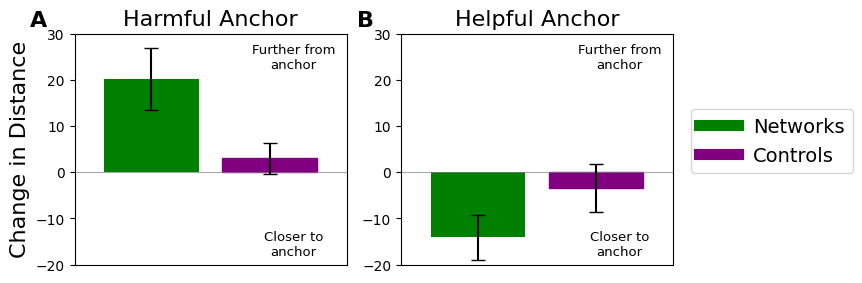

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].plot([-1,4],[0,0],'-',color='gray',lw=0.5)
axs[0].set_xlim(-.65,1.65)
bars = axs[0].bar([0,1],df_individuals.Away,color='green')
bars[1].set_color('purple')
axs[0].errorbar([0,1], df_individuals.Away, yerr=df_individuals.Away_cis, fmt='none', ecolor='black', capsize=5)
axs[0].set_xticks([])
axs[0].set_title('Harmful Anchor',fontsize=16)
axs[0].set_ylim(-20,30)
axs[0].set_ylabel(r'Change in Distance',fontsize=16)
axs[0].set_xlim(-.65,1.65)
axs[0].annotate('Closer to\nanchor', xy=(1.2, -18), xytext=(1.2, -18), ha='center', fontsize=9.5)
axs[0].annotate('Further from\nanchor', xy=(1.2, 22.5), xytext=(1.2, 22.5), ha='center', fontsize=9.5)

axs[1].plot([-1,4],[0,0],'-',color='gray',lw=0.5)
axs[1].set_xlim(-.65,1.65)
bars_1 = axs[1].bar([0,1],df_individuals.Toward,color='green')
bars_1[1].set_color('purple')
axs[1].errorbar([0,1], df_individuals.Toward, yerr=df_individuals.Toward_cis, fmt='none', ecolor='black', capsize=5)
axs[1].set_xticks([])
axs[1].set_title('Helpful Anchor',fontsize=16)
axs[1].set_ylim(-20,30)
axs[1].set_xlim(-.65,1.65)
axs[1].annotate('Closer to\nanchor', xy=(1.2, -18), xytext=(1.2, -18), ha='center', fontsize=9.5)
axs[1].annotate('Further from\nanchor', xy=(1.2, 22.5), xytext=(1.2, 22.5), ha='center', fontsize=9.5)
custom_lines = [Line2D([0], [0], color='green', lw=8),
                Line2D([0], [0], color='purple', lw=8)]

# Use these custom lines for the legend
fig.legend(handles=custom_lines, labels=['Networks', 'Controls'], loc='center right', fontsize=14)

axs[0].text(-0.1, 1.1, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].text(-0.1, 1.1, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


plt.subplots_adjust(right=0.79)
plt.savefig('Figures/Figure-2_Change-Distance.png', dpi=300)
plt.show()



In [8]:
print('Percentage_Changes')
# HARMFUL & HELPFUL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Dist_Anchor_1': np.median,
                                            'Dist_Anchor_2': np.median, 'Dist_Anchor_3': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con.reset_index(level=['Matched'], inplace=True)
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Dist_Anchor_2'] / df_con['Dist_Anchor_1']) * 100
df_con['R_3'] = (1 - df_con['Dist_Anchor_3'] / df_con['Dist_Anchor_1']) * 100


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Dist_Anchor_1': np.median,
                                              'Dist_Anchor_2': np.median, 'Dist_Anchor_3': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net.reset_index(level=['Matched'], inplace=True)
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Dist_Anchor_2'] / df_net['Dist_Anchor_1']) * 100
df_net['R_3'] = (1 - df_net['Dist_Anchor_3'] / df_net['Dist_Anchor_1']) * 100

print('\nBy network Helpful')

df_temp = df_net.loc[df_net.Matched == 1]
df_temp_con = df_con.loc[df_con.Matched == 1]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))

print('\nHarmful')
df_temp = df_net.loc[df_net.Matched == 0]
df_temp_con = df_con.loc[df_con.Matched == 0]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))


Percentage_Changes

By network Helpful
Percentage change: 13.551811477933128
MannwhitneyuResult(statistic=315.0, pvalue=0.001951434200557612)

Harmful
Percentage change: -28.73448230757456
MannwhitneyuResult(statistic=96.5, pvalue=0.005256565421279703)


# Figure 3 - Error across rounds

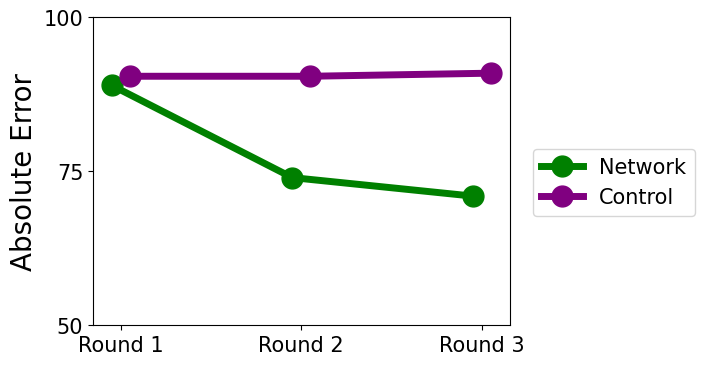

In [9]:
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

axs.plot([-0.05, .95, 1.95],[df_net[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='green', ms = 15, lw=5, label='Network')
axs.plot([0.05, 1.05, 2.05],[df_con[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='purple', ms = 15, lw=5, label='Control')

axs.set_xticks([0, 1, 2], ['Round 1', 'Round 2', 'Round 3'], fontsize=15)
axs.set_ylabel('Absolute Error', fontsize=20)
axs.set_ylim(50, 100)
axs.set_yticks([50, 75, 100], ['50', '75', '100'], fontsize=15)
fig.legend(fontsize=15,loc='center right')
plt.subplots_adjust(right=0.72)
plt.savefig('Figures/Figure-3_Change-Error.png', dpi=300)
plt.show()



In [10]:
# Percentage ERROR

# OVERALL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Second_Error'] / df_net['Initial_Error']) * 100
df_net['R_3'] = (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100

print('Individual = OVER ALL the conditions (i.e., low and high anchor)')
print('Percentage change:',np.mean(df_net['R_3']) - np.mean(df_con['R_3']))
print(stats.mannwhitneyu(df_net['R_3'], df_con['R_3']))



# HARMFUL & HELPFUL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con.reset_index(level=['Matched'], inplace=True)
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net.reset_index(level=['Matched'], inplace=True)
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Second_Error'] / df_net['Initial_Error']) * 100
df_net['R_3'] = (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100

print('\nIndividual = Helpful')

df_temp = df_net.loc[df_net.Matched == 1]
df_temp_con = df_con.loc[df_con.Matched == 1]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))

print('\nIndividual = Harmful')
df_temp = df_net.loc[df_net.Matched == 0]
df_temp_con = df_con.loc[df_con.Matched == 0]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))



Individual = OVER ALL the conditions (i.e., low and high anchor)
Percentage change: 22.18252545296794
MannwhitneyuResult(statistic=366.0, pvalue=7.4295758209643e-06)

Individual = Helpful
Percentage change: 20.692801485174357
MannwhitneyuResult(statistic=373.0, pvalue=3.0560545995387447e-06)

Individual = Harmful
Percentage change: 25.435559998572966
MannwhitneyuResult(statistic=303.5, pvalue=0.00521187694347634)


# Figure 4 - Revision Coefficient

In [11]:

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_3'])
df_temp = df_temp.loc[df_temp['neighbors_1'] != 'None']
df_temp['neighbors_1'] = df_temp['neighbors_1'].astype('float')
df_temp['Social_signal'] = df_temp['response_1'] - df_temp['neighbors_1']
print(pg.partial_corr(data=df_temp, x='Initial_Error', y='Mag_Rev', covar='Social_signal',method='spearman').round(3))
print('General Correlation:', stats.spearmanr(df_temp['Initial_Error'], df_temp['Mag_Rev']))

# Must perform the Jonckheere-Terpstra Test in R -- though the result matches what's here.

            n      r         CI95%  p-val
spearman  730  0.207  [0.14, 0.28]    0.0
General Correlation: SpearmanrResult(correlation=0.16934152870008198, pvalue=4.2090551427591586e-06)


# Figure 5 - Accuracy and improvement by confidence

In [12]:


df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['final_confidence_rank'] = df.final_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})

### INITIAL Confidence in Self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['initial_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(str)
model_1_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1 = smf.ols('Final_Error ~ Initial_Error + initial_confidence_rank', data=df_temp).fit()

# Final Confidence in self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['final_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(str)
model_1_nocb = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1b = smf.ols('Final_Error ~ Initial_Error + final_confidence_rank', data=df_temp).fit()


# Confidence in neighbors
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['neighbor_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(str)
model_2_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_2 = smf.ols('Final_Error ~ Initial_Error + neighbor_confidence_rank', data=df_temp).fit()


In [13]:

# Anova results show confidence in self never improves fit--only neighbors
anova_results = anova_lm(model_1_noc, model_1)
print(anova_results)

anova_results = anova_lm(model_1_nocb, model_1b)
print(anova_results)

anova_results = anova_lm(model_2_noc, model_2)
print(anova_results)

df_temp = df[['Initial_Error','initial_confidence_rank','neighbor_confidence_rank','final_confidence_rank']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
print('Self confidence',stats.spearmanr(df_temp['initial_confidence_rank'], df_temp['Initial_Error']))
print('And final',stats.spearmanr(df_temp['final_confidence_rank'], df_temp['Initial_Error']))

df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
print('Neighbor confidence:',stats.spearmanr(df_temp['neighbor_confidence_rank'], df_temp['Initial_Error']))

#print(model_1.summary())
#print(model_1b.summary())
#print(model_2.summary())


   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0          NaN       NaN       NaN
1     721.0  837343.919964      3.0  5455.960501  1.565962  0.196296
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0          NaN       NaN       NaN
1     721.0  838146.954934      3.0  4652.925531  1.334197  0.262082
   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0           NaN       NaN       NaN
1     721.0  824655.541381      3.0  18144.339084  5.287892  0.001305
Self confidence SpearmanrResult(correlation=0.012222927160991397, pvalue=0.648413970099261)
And final SpearmanrResult(correlation=0.003428479025608667, pvalue=0.8982342059149383)
Neighbor confidence: SpearmanrResult(correlation=-0.07549751093950936, pvalue=0.04073261068009544)


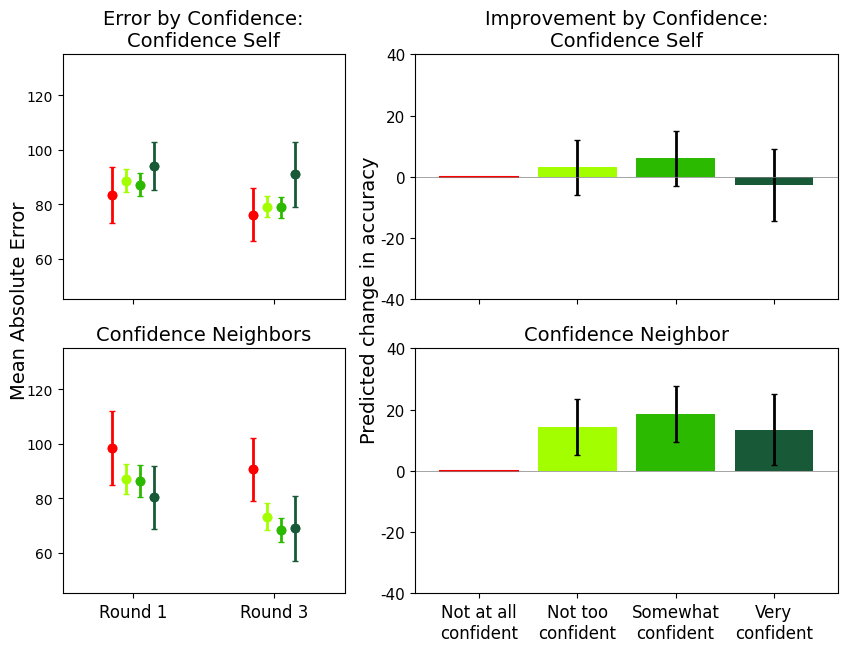

In [14]:
# Plot these results

fig, axs = plt.subplots(2,2,figsize=(10,7),gridspec_kw={'width_ratios': [1, 1.5]})

# Confidence in self -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
colors = ['#ff0000','#a3ff00','#2cba00','#185a37']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.initial_confidence == o]
    axs[0,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None')
    axs[0,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[0,0].set_xticks([1,2])
axs[0,0].set_xticklabels(['',''])
axs[0,0].set_xlim(0.5,2.5)
axs[0,0].set_title('Error by Confidence:\nConfidence Self', fontsize = 14)
axs[0,0].set_ylim(45,135)


# Confidence in neighbors -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.neighbor_confidence == o]
    axs[1,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None',label='Control')
    axs[1,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[1,0].set_xticks([1,2])
axs[1,0].set_xticklabels(['Round 1', 'Round 3'], fontsize = 12)
axs[1,0].set_ylabel('Mean Absolute Error', fontsize = 14)
axs[1,0].yaxis.set_label_coords(-0.12,1.2)
axs[1,0].set_xlim(0.5,2.5)
axs[1,0].set_title('Confidence Neighbors', fontsize = 14)
axs[1,0].set_ylim(45,135)



# Create a bar plot of the change in accuracy for each confidence level
i = 1
for o in options[:-1]:
    axs[0,1].bar([0+i],[-model_1.params[i]], color=colors[i],label='Control')
    axs[0,1].errorbar([0+i],[-model_1.params[i]],
                [1.96 * model_1.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[0,1].set_xticks([0,1,2,3])
axs[0,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[0,1].set_xticklabels(["","","",""])
axs[0,1].set_title('Improvement by Confidence:\nConfidence Self', fontsize = 14)
axs[0,1].set_yticks([-40,-20,0, 20,40])
axs[0,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11)
axs[0,1].set_ylim(-40,40)
axs[0,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[0,1].set_xlim(-.65,3.65)

# Confidence in neighbors -------------------------------------------
options = ['Not at all\nconfident', 'Not too\nconfident', 'Somewhat\nconfident', 'Very\nconfident']

i = 1
for o in options[:-1]:
    axs[1,1].bar([0+i],[-model_2.params[i]], color=colors[i],label='Control')
    axs[1,1].errorbar([0+i],[-model_2.params[i]],
                [1.96 * model_2.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[1,1].set_xticks([0,1,2,3])
axs[1,1].set_yticks([-40,-20,0, 20,40])
axs[1,1].plot()
axs[1,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11)
axs[1,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[1,1].set_xticklabels(options, fontsize = 12)
axs[1,1].set_ylabel('Predicted change in accuracy', fontsize = 14)
axs[1,1].yaxis.set_label_coords(-0.085,1.2)
axs[1,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[1,1].set_xlim(-.65,3.65)
axs[1,1].set_title('Confidence Neighbor', fontsize = 14)
axs[1,1].set_ylim(-40,40)

#plt.tight_layout()
plt.savefig('Figures/Figure-4_Confidence.png', dpi=300)
plt.show()


# SI-Appendix

# Individual-level results

In [15]:
df['change_anchor'] = df['Dist_Anchor_3'] - df['Dist_Anchor_1']
df_temp = df[['group','Net_type','Condition','Matched','Change_accuracy','change_anchor']].dropna()

print('Change in accuracy by condition')
print(df_temp.loc[df_temp.Net_type == 'Network'].Change_accuracy.median(), df_temp.loc[df_temp.Net_type == 'Control'].Change_accuracy.median())
print(stats.mannwhitneyu(df_temp.loc[df_temp.Net_type == 'Network'].Change_accuracy, df_temp.loc[df_temp.Net_type == 'Control'].Change_accuracy))

print('Change in distance to anchor by condition')
df_matched = df_temp.loc[df_temp.Matched == 1]
df_unmatched = df_temp.loc[df_temp.Matched == 0]

print('Helpful')
print(df_matched.loc[df_matched.Net_type == 'Network'].change_anchor.median(), df_matched.loc[df_matched.Net_type == 'Control'].change_anchor.median())
print(stats.wilcoxon(df_matched.loc[df_matched.Net_type == 'Network'].change_anchor))

print('Harmful')
print(df_unmatched.loc[df_unmatched.Net_type == 'Network'].change_anchor.median(), df_unmatched.loc[df_unmatched.Net_type == 'Control'].change_anchor.median())
print(stats.wilcoxon(df_unmatched.loc[df_unmatched.Net_type == 'Network'].change_anchor))

Change in accuracy by condition
7.0 0.0
MannwhitneyuResult(statistic=297414.0, pvalue=4.350101028521594e-12)
Change in distance to anchor by condition
Helpful
-10.0 0.0
WilcoxonResult(statistic=11295.0, pvalue=2.6379022793499755e-20)
Harmful
2.0 0.0
WilcoxonResult(statistic=9817.5, pvalue=2.4720077948824165e-09)


In [16]:
df_temp = df[['group','Initial_Error','Net_type','Second_Error','Final_Error','Change_accuracy']].dropna()
reg_model = smf.ols("Change_accuracy ~ C(Net_type) + C(group)", df_temp).fit(cov_type='cluster', cov_kwds={'groups': df_temp['group']})
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Change_accuracy   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                 1.271e+30
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:09:52   Log-Likelihood:                -11450.
No. Observations:                1395   AIC:                         2.298e+04
Df Residuals:                    1355   BIC:                         2.319e+04
Df Model:                          39                                         
Covariance Type:              cluster                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.9394    2.8e-13   1.05e+13      0.000       2.939       2.939
C(Net_type)[T.Network]    65.7854   3.56e-13   1.85e+14      0.000      65.785      65.785
C(group)[T.1]             -4.5644   3.13e-13  -1.46e+13      0.000      -4.564      -4.564
C(group)[T.2]             -0.3910   3.57e-13  -1.09e+12      0.000      -0.391      -0.391
C(group)[T.3]             -2.1269   2.94e-13  -7.25e+12      0.000      -2.127      -2.127
C(group)[T.4]              5.8106   2.98e-13   1.95e+13      0.000       5.811       5.811
C(group)[T.5]              1.4724   3.44e-13   4.28e+12      0.000       1.472       1.472
C(group)[T.6]              4.3333   2.85e-13   1.52e+13      0.000       4.333       4.333
C(group)[T.7]             13.0606   3.29e-13   3.97e+13      0.000      13.061      13.061
C(group)[T.8]             -2.7576   2.95e-13  -9.36e+12      0.000      -2.758      -2.758
C(group)[T.9]             -8.1975   2.97e-13  -2.76e+13      0.000      -8.197      -8.197
C(group)[T.10]           -10.7576   2.99e-13   -3.6e+13      0.000     -10.758     -10.758
C(group)[T.11]             0.6783   2.82e-13   2.41e+12      0.000       0.678       0.678
C(group)[T.12]            -2.5865   2.83e-13  -9.14e+12      0.000      -2.586      -2.586
C(group)[T.13]           -10.3989    2.9e-13  -3.59e+13      0.000     -10.399     -10.399
C(group)[T.14]            -1.6823   2.84e-13  -5.92e+12      0.000      -1.682      -1.682
C(group)[T.15]           216.8731   2.81e-13   7.71e+14      0.000     216.873     216.873
C(group)[T.16]            -9.8144   3.67e-13  -2.68e+13      0.000      -9.814      -9.814
C(group)[T.17]            -4.9394    2.8e-13  -1.76e+13      0.000      -4.939      -4.939
C(group)[T.18]            -1.7772   3.02e-13  -5.88e+12      0.000      -1.777      -1.777
C(group)[T.19]             5.6273    2.8e-13   2.01e+13      0.000       5.627       5.627
C(group)[T.20]           -65.9533   4.53e-13  -1.46e+14      0.000     -65.953     -65.953
C(group)[T.21]           -62.5819   2.62e-13  -2.39e+14      0.000     -62.582     -62.582
C(group)[T.22]           -66.5932   7.24e-13   -9.2e+13      0.000     -66.593     -66.593
C(group)[T.23]           -54.0491   4.61e-13  -1.17e+14      0.000     -54.049     -54.049
C(group)[T.24]           -55.5303   4.19e-13  -1.32e+14      0.000     -55.530     -55.530
C(group)[T.25]           -61.1490   2.36e-13  -2.59e+14      0.000     -61.149     -61.149
C(group)[T.26]           -62.8359   2.37e-13  -2.65e+14      0.000     -62.836     -62.836
C(group)[T.27]           -47.9353    3.7e-13   -1.3e+14      0.000     -47.935     -47.935
C(group)[T.28]           -62.6970   3.59e-13  -1.74e+14      0.000     -62.697     -62.697
C(group)[T.29]           -62.9748    2.6e-13  -2.42e+14      0.000     -62.975  

# Improvement by Anchoring

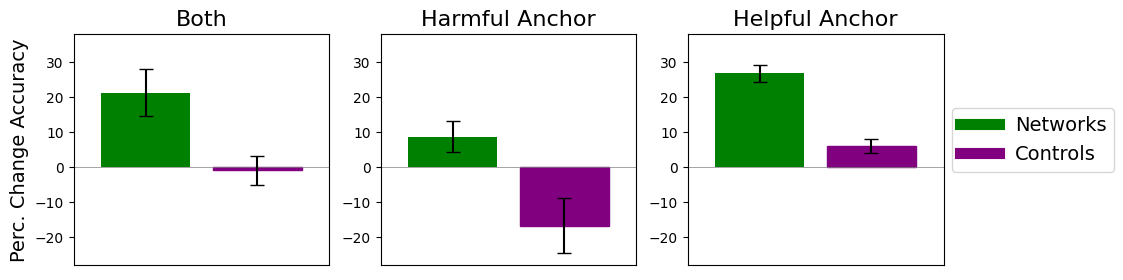

In [17]:
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con['Change'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100
df_con['R_1'] = 100
df_con['R_2'] = df_con['Second_Error'] / df_con['Initial_Error'] * 100
df_con['R_3'] = df_con['Final_Error'] / df_con['Initial_Error'] * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net['Change'] =  (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100
df_net['R_1'] = 100
df_net['R_2'] = df_net['Second_Error'] / df_net['Initial_Error'] * 100
df_net['R_3'] = df_net['Final_Error'] / df_net['Initial_Error'] * 100

df_net_both = df_net
df_con_both = df_con

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
# Overall
axs[0].plot([-1,4],[0,0],'-',color='gray',lw=0.5)
axs[0].set_xlim(-.65,1.65)
bars = axs[0].bar([0,1],[df_net.Change.mean(), df_con.Change.mean()],color='green')
bars[1].set_color('purple')
axs[0].errorbar([0,1], [df_net.Change.mean(), df_con.Change.mean()], yerr=[1.96*df_net['Change'].std() / np.sqrt(df_net['Change'].count()),
                                                                           1.96*df_con['Change'].std() / np.sqrt(df_con['Change'].count())], fmt='none', ecolor='black', capsize=5)
axs[0].set_xticks([])
axs[0].set_title('Both',fontsize=16)
axs[0].set_ylim(-28,38)
axs[0].set_ylabel(r'Perc. Change Accuracy',fontsize=14)



df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con.reset_index(level=['Matched'], inplace=True)
df_con['Change'] =  (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100
df_con['R_1'] = 100
df_con['R_2'] = df_con['Second_Error'] / df_con['Initial_Error'] * 100
df_con['R_3'] = df_con['Final_Error'] / df_con['Initial_Error'] * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net.reset_index(level=['Matched'], inplace=True)
df_net['Change'] =  (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100
df_net['R_1'] = 100
df_net['R_2'] = df_net['Second_Error'] / df_net['Initial_Error'] * 100
df_net['R_3'] = df_net['Final_Error'] / df_net['Initial_Error'] * 100


axs[1].plot([-1,4],[0,0],'-',color='gray',lw=0.5)
axs[1].set_xlim(-.65,1.65)
bars = axs[1].bar([0,1],[df_net.loc[df_net.Matched == 0].Change.mean(),df_con.loc[df_con.Matched == 0].Change.mean()],color='green')
bars[1].set_color('purple')
axs[1].errorbar([0,1], [df_net.loc[df_net.Matched == 0].Change.mean(),df_con.loc[df_con.Matched == 0].Change.mean()], 
                yerr=[df_net.loc[df_net.Matched == 0].Change.std()/np.sqrt(df_net.loc[df_net.Matched == 0].Change.count()),
                      df_con.loc[df_con.Matched == 0].Change.std()/np.sqrt(df_net.loc[df_net.Matched == 0].Change.count())], fmt='none', ecolor='black', capsize=5)
axs[1].set_xticks([])
axs[1].set_title('Harmful Anchor',fontsize=16)
axs[1].set_ylim(-28,38)


axs[2].plot([-1,4],[0,0],'-',color='gray',lw=0.5)
axs[2].set_xlim(-.65,1.65)
bars = axs[2].bar([0,1],[df_net.loc[df_net.Matched == 1].Change.mean(),df_con.loc[df_con.Matched == 1].Change.mean()],color='green')
bars[1].set_color('purple')
axs[2].errorbar([0,1], [df_net.loc[df_net.Matched == 1].Change.mean(),df_con.loc[df_con.Matched == 1].Change.mean()], 
                yerr=[df_net.loc[df_net.Matched == 1].Change.std()/np.sqrt(df_net.loc[df_net.Matched == 1].Change.count()),
                      df_con.loc[df_con.Matched == 1].Change.std()/np.sqrt(df_net.loc[df_net.Matched == 1].Change.count())], fmt='none', ecolor='black', capsize=5)
axs[2].set_xticks([])
axs[2].set_title('Helpful Anchor',fontsize=16)
axs[2].set_ylim(-28,38)

custom_lines = [Line2D([0], [0], color='green', lw=8),
                Line2D([0], [0], color='purple', lw=8)]

# Use these custom lines for the legend
fig.legend(handles=custom_lines, labels=['Networks', 'Controls'], loc='center right', fontsize=14)
plt.subplots_adjust(right=0.85)
plt.savefig('Figures/SI-Change-Accuracy-help-harm.png', dpi=300)
plt.show()



# Revision coefficient figure

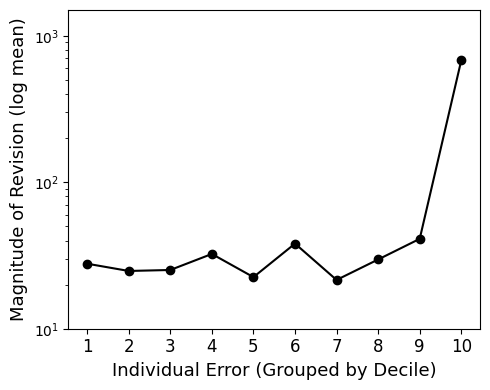

General Correlation: SpearmanrResult(correlation=0.16724640587771106, pvalue=5.8834707805514845e-06)


In [18]:
df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp['Initial_Error_Bin'] = pd.cut(df_temp.Initial_Error, bins=[int(round(i,0)) for i in df_temp['Initial_Error'].quantile([i * .1 for i in range(11)])])
d = df_temp.groupby('Initial_Error_Bin').agg({'Mag_Rev': [np.mean, stats.sem]})

# Raw mean
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot([i for i in range(10)], d['Mag_Rev'].values[:,0],'-o',color='black')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10], fontsize=12)
ax.set_xlabel('Individual Error (Grouped by Decile)', fontsize = 13)
ax.set_ylabel('Magnitude of Revision (log mean)', fontsize= 13)
ax.set_ylim(10, 1500)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('Figures/SI-Revision-Coef.png', dpi=300)
plt.show()


df_temp = df_temp.dropna(subset = ['Initial_Error','Mag_Rev'])
print('General Correlation:', stats.spearmanr(df_temp['Initial_Error'], df_temp['Mag_Rev']))

# Inclusion of outliers Confidence

In [19]:

df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['final_confidence_rank'] = df.final_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})

# Create a multiple regression with the outcome variable being final error and the predictors being initial error and neighbor confidence
#df_temp = df.loc[df.N == 40] # If you only want to look at people in networks use this line and change next to df_temp
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['initial_confidence_rank', 'Initial_Error','Final_Error']].dropna()
#df_temp = df_temp.loc[df.Initial_Error < 492]
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(str)

model_1b = smf.ols('Final_Error ~ Initial_Error + initial_confidence_rank', data=df_temp).fit()


# Create a multiple regression with the outcome variable being final error and the predictors being initial error and neighbor confidence
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['neighbor_confidence_rank', 'Initial_Error','Final_Error']].dropna()
#df_temp = df_temp.loc[df.Initial_Error < 492]
df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(str)

model_2b = smf.ols('Final_Error ~ Initial_Error + neighbor_confidence_rank', data=df_temp).fit()

In [20]:
# Outlier models for comparison
print('Confidence in self:')
print(model_1b.summary())
print('Confidence in others:')
print(model_2b.summary())

Confidence in self:
                            OLS Regression Results                            
Dep. Variable:            Final_Error   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7429
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.563
Time:                        16:10:10   Log-Likelihood:                -3808.6
No. Observations:                 730   AIC:                             7627.
Df Residuals:                     725   BIC:                             7650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# Interaction between Change in accuracy and error

In [21]:
df_net = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_3'])
def group(c):
    if c in ['Not at all confident', 'Not too confident']:
        return 'Not confident'
    elif c in ['Somewhat confident', 'Very confident']:
        return 'Confident'
    
df_net['Group'] = df_net['neighbor_confidence'].apply(group)

# Run regression Change Accuracy ~ Initial Error * Group
model_c = smf.ols('Change_accuracy ~ Initial_Error * Group', data=df_net).fit()
print('Neighbors',model_c.params[3], model_c.pvalues[3])

# Robust to the inclusion of outliers
df_no_outlier = df_net.loc[df_net.Initial_Error < 500]
model_c = smf.ols('Change_accuracy ~ Initial_Error * Group', data=df_no_outlier).fit()
#print(model_c.summary())
print('No outliers, Neighbors',model_c.params[3], model_c.pvalues[3])

df_net['Group'] = df_net['initial_confidence'].apply(group)

# Run regression Change Accuracy ~ Initial Error * Group
model_c = smf.ols('Change_accuracy ~ Initial_Error * Group', data=df_net).fit()
#print(model_c.summary())

# Print the fourth coefficient and associated p-value
print('Self:',model_c.params[3], model_c.pvalues[3])

Neighbors -0.43929055972793274 7.734581130963764e-43
No outliers, Neighbors -0.1732914025545034 0.0001645407285516133
Self: 0.002316424333069651 0.6303849014132308


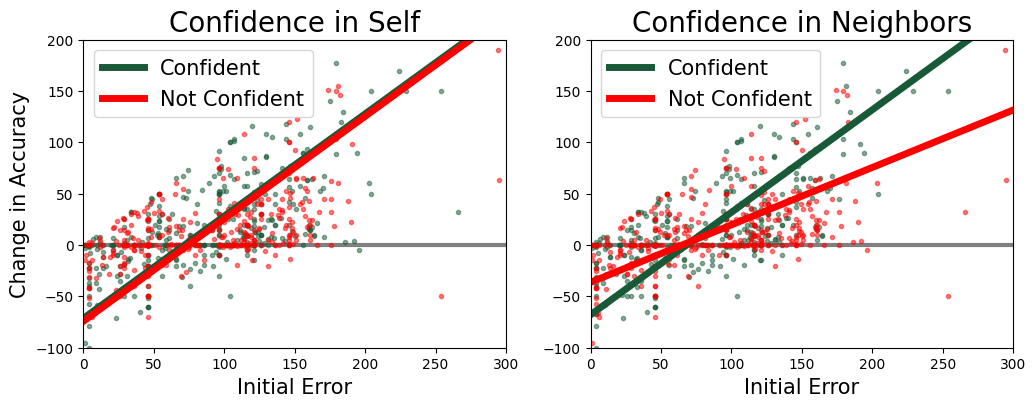

In [22]:
df_net = df.loc[df.Net_type == 'Network'].dropna(subset = ['Initial_Error','Final_Error'])
df_net['Change_Accuracy'] = df_net['Initial_Error'] - df_net['Final_Error']
#df_net = df_net.loc[df_net['Initial_Error'] < 492]


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

conf = ['initial_confidence', 'neighbor_confidence']
title = ['Confidence in Self','Confidence in Neighbors']
for i in range(2):
    df_net['Group'] = df_net[conf[i]].apply(group)
    df_not_conf = df_net.loc[df_net.Group == 'Not confident']
    df_conf = df_net.loc[df_net.Group == 'Confident']

    axs[i].hlines(0, 0, 500, color='gray', lw=3)
    axs[i].plot(df_conf.Initial_Error, df_conf.Change_Accuracy, 'o', color='#185a37', ms=3,alpha=0.5)
    axs[i].plot(df_not_conf.Initial_Error, df_not_conf.Change_Accuracy, 'o', color='#ff0000', ms=3,alpha=0.5)

    # Add best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_conf.Initial_Error, df_conf.Change_Accuracy)
    axs[i].plot([0, 500], [intercept, intercept + slope * 500], '-', color='#185a37', lw=5, label = 'Confident')
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_not_conf.Initial_Error, df_not_conf.Change_Accuracy)
    axs[i].plot([0, 500], [intercept, intercept + slope * 500], '-', color='#ff0000', lw=5, label = 'Not Confident')

    axs[i].set_xlabel('Initial Error', fontsize=15)
    axs[i].legend(fontsize=15)
    axs[i].set_xlim(0,300)
    axs[i].set_ylim(-100,200)
    axs[i].set_title(title[i], fontsize=20)

axs[0].set_ylabel('Change in Accuracy', fontsize=15)
plt.savefig('Figures/SI-Confidence-Interaction.png', dpi=300)
plt.show()



# Non-parametric Confidence

In [23]:
print('Confidence in neighbors')
df_net = df.loc[df.Net_type == 'Network']
def group(c):
    if c in ['Not at all confident', 'Not too confident']:
        return 'Not confident'
    elif c in ['Somewhat confident', 'Very confident']:
        return 'Confident'
    
df_net['Group'] = df_net['neighbor_confidence'].apply(group)
df_net = df_net.dropna(subset=['Change_accuracy','Group'])

# Group participants in conf/non-conf into top and bottom 50% of initial error
df_conf = df_net.loc[df_net.Group == 'Confident']
df_not_conf = df_net.loc[df_net.Group == 'Not confident']

df_conf_low = df_conf.loc[df_conf.Initial_Error < df_conf.Initial_Error.median()]
df_conf_high = df_conf.loc[df_conf.Initial_Error >= df_conf.Initial_Error.median()]
df_not_conf_low = df_not_conf.loc[df_not_conf.Initial_Error < df_not_conf.Initial_Error.median()]
df_not_conf_high = df_not_conf.loc[df_not_conf.Initial_Error >= df_not_conf.Initial_Error.median()]
print(df_conf_low.Change_accuracy.count(), df_conf_high.Change_accuracy.count(), df_not_conf_low.Change_accuracy.count(), df_not_conf_high.Change_accuracy.count())
print(df_conf_low.Change_accuracy.median(), df_conf_high.Change_accuracy.median(), df_not_conf_low.Change_accuracy.median(), df_not_conf_high.Change_accuracy.median())
print('Low Error compare',stats.mannwhitneyu(df_conf_low.Change_accuracy, df_not_conf_low.Change_accuracy))
print('High Error compare',stats.mannwhitneyu(df_conf_high.Change_accuracy, df_not_conf_high.Change_accuracy))

Confidence in neighbors
184 184 176 186
0.0 25.5 0.0 17.5
Low Error compare MannwhitneyuResult(statistic=15111.0, pvalue=0.2705376414608641)
High Error compare MannwhitneyuResult(statistic=19586.0, pvalue=0.01598033833357599)


In [24]:
print('Confidence in Self')
df_net = df.loc[df.Net_type == 'Network']
def group(c):
    if c in ['Not at all confident', 'Not too confident']:
        return 'Not confident'
    elif c in ['Somewhat confident', 'Very confident']:
        return 'Confident'
    
df_net['Group'] = df_net['final_confidence'].apply(group)
df_net = df_net.dropna(subset=['Change_accuracy','Group'])

# Non-parametric test
df_conf = df_net.loc[df_net.Group == 'Confident']
df_not_conf = df_net.loc[df_net.Group == 'Not confident']

# Group participants in conf/non-conf into top and bottom 50% of initial error
df_conf_low = df_conf.loc[df_conf.Initial_Error < df_conf.Initial_Error.median()]
df_conf_high = df_conf.loc[df_conf.Initial_Error >= df_conf.Initial_Error.median()]
df_not_conf_low = df_not_conf.loc[df_not_conf.Initial_Error < df_not_conf.Initial_Error.median()]
df_not_conf_high = df_not_conf.loc[df_not_conf.Initial_Error >= df_not_conf.Initial_Error.median()]
print(df_conf_low.Change_accuracy.count(), df_conf_high.Change_accuracy.count(), df_not_conf_low.Change_accuracy.count(), df_not_conf_high.Change_accuracy.count())
print(df_conf_low.Change_accuracy.median(), df_conf_high.Change_accuracy.median(), df_not_conf_low.Change_accuracy.median(), df_not_conf_high.Change_accuracy.median())
print(stats.mannwhitneyu(df_conf_low.Change_accuracy, df_not_conf_low.Change_accuracy))
print(stats.mannwhitneyu(df_conf_high.Change_accuracy, df_not_conf_high.Change_accuracy))

Confidence in Self
253 257 103 117
0.0 20.0 0.0 20.0
MannwhitneyuResult(statistic=12520.0, pvalue=0.5607620202278705)
MannwhitneyuResult(statistic=16050.5, pvalue=0.29381214707986303)


# Confidence round 3

In [25]:


df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['final_confidence_rank'] = df.final_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})

# Create a multiple regression with the outcome variable being final error and the predictors being initial error and neighbor confidence
#df_temp = df.loc[df.N == 40] # If you only want to look at people in networks use this line and change next to df_temp
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['final_confidence_rank', 'Initial_Error','Final_Error']].dropna()

df_temp = df_temp.loc[df_temp.Initial_Error < 492]

df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(str)

model_1_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1 = smf.ols('Final_Error ~ Initial_Error + final_confidence_rank', data=df_temp).fit()


# Create a multiple regression with the outcome variable being final error and the predictors being initial error and neighbor confidence
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['final_confidence_rank', 'neighbor_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp = df_temp.loc[df_temp.final_confidence_rank != 'None']
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(int)
df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(str)
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(str)

model_2_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_2 = smf.ols('Final_Error ~ Initial_Error + final_confidence_rank + neighbor_confidence_rank', data=df_temp).fit()


anova_results = anova_lm(model_1_noc, model_1)
print('Does final confidence provide more improvement on its own?')
print(anova_results)

anova_results = anova_lm(model_1, model_2)
print('Does neighbor confidene add predictive power compared to final confidence?')
print(anova_results)


Does final confidence provide more improvement on its own?
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0          NaN       NaN       NaN
1     721.0  838146.954934      3.0  4652.925531  1.334197  0.262082
Does neighbor confidene add predictive power compared to final confidence?
   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0     721.0  838146.954934      0.0           NaN       NaN       NaN
1     718.0  824573.623577      3.0  13573.331357  3.939673  0.008364


# Crowd-level results

In [26]:
df = pd.read_csv('ci_cb_2023-06-26.csv')

df['Anchor'] = np.where(df['Condition'] == 'Low', 118, 353)
df['Mag_Rev1'] = abs(df['response_2'] - df['response_1'])
df['Mag_Rev2'] = abs(df['response_3'] - df['response_2'])
df['Mag_Rev'] = abs(df['response_3'] - df['response_1'])
df['Initial_Error'] = abs(df['response_1'] - df['true_answer'])
df['Second_Error'] = abs(df['response_2'] - df['true_answer'])
df['Final_Error'] = abs(df['response_3'] - df['true_answer'])
df['Dist_Anchor_1'] = abs(df['response_1'] - df['Anchor'])
df['Dist_Anchor_2'] = abs(df['response_2'] - df['Anchor'])
df['Dist_Anchor_3'] = abs(df['response_3'] - df['Anchor'])
df['Difference_Initial_Anchor'] = df['response_1'] - df['Anchor']
df['Difference_Initial_Truth'] = df['response_1'] - 246
df['Matched'] = np.where(df['Difference_Initial_Anchor'] * df['Difference_Initial_Truth'] > 0, 1, 0)
df['Change_accuracy'] = df['Initial_Error'] - df['Final_Error']

In [27]:
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_temp_con['Accuracy_1'] = abs(df_temp_con.response_1 - 246)
df_temp_con['Accuracy_2'] = abs(df_temp_con.response_2 - 246)
df_temp_con['Accuracy_3'] = abs(df_temp_con.response_3 - 246)


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_2'] = abs(df_temp.response_2 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

print('Accuracy over all the conditions (i.e., low and high anchor)')
print('Initial Difference Group',np.mean(df_temp['Accuracy_1']), np.mean(df_temp_con['Accuracy_1']))
print(stats.mannwhitneyu(df_temp['Accuracy_1'], df_temp_con['Accuracy_1']))
print('Change over time',np.mean(df_temp['Accuracy_3'] - df_temp['Accuracy_1']), np.mean(df_temp_con['Accuracy_3'] - df_temp_con['Accuracy_1']))
print(stats.mannwhitneyu((df_temp['Accuracy_3'] - df_temp['Accuracy_1']), (df_temp_con['Accuracy_3'] - df_temp_con['Accuracy_1'])))
print('Network',stats.wilcoxon(df_temp['Accuracy_3'] - df_temp['Accuracy_1']))
print('Control',stats.wilcoxon(df_temp_con['Accuracy_3'] - df_temp_con['Accuracy_1']))



# Crowd level distance to the anchor 
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Anchor': 'first', 'Condition': 'first'})

# Calculate the difference between response 1/3 and anchor and how it changes across rounds
df_temp['Dif_1'] = abs(df_temp.response_1 - df_temp.Anchor)
df_temp['Dif_3'] = abs(df_temp.response_3 - df_temp.Anchor)
df_temp['Change'] =  df_temp['Dif_3'] - df_temp['Dif_1']

# Group by whether the anchor is in the direction of truth (Matched == 1) or not (Matched == 0)
df_temp['Difference_Initial_Anchor'] = df_temp['response_1'] - df_temp['Anchor']
df_temp['Difference_Initial_Truth'] = df_temp['response_1'] - 246
df_temp['Matched'] = np.where(df_temp['Difference_Initial_Anchor'] * df_temp['Difference_Initial_Truth'] > 0, 1, 0)
df_network = df_temp.copy()
df_t_n = df_temp.loc[df_temp.Matched == 1].dropna(subset=['Dif_1', 'Dif_3'])
df_f_n = df_temp.loc[df_temp.Matched == 0].dropna(subset=['Dif_1', 'Dif_3'])

print('\n\nProximity to anchor networks')
print('Helpful Change: ',df_t_n['Change'].mean())
print(stats.wilcoxon(df_t_n.Change, method='approx',correction=False))
print('Harmful Change: ',df_f_n['Change'].mean())
print(stats.wilcoxon(df_f_n.Change, method='approx',correction=False))



# Control Group Level
df_temp = df.loc[df.Net_type == 'Control']
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_3': np.median, 'Anchor': np.median})
df_temp = df_temp.loc[~df_temp.index.isin([18])]

# Calculate the difference between response 1/3 and anchor  and how it changes across rounds
df_temp['Dif_1'] = abs(df_temp.response_1 - df_temp.Anchor)
df_temp['Dif_3'] = abs(df_temp.response_3 - df_temp.Anchor)
df_temp['Change'] =  df_temp['Dif_3'] - df_temp['Dif_1']

# Group by whether the anchor is in the direction of truth (Matched == 1) or not (Matched == 0)
df_temp['Difference_Initial_Anchor'] = df_temp['response_1'] - df_temp['Anchor']
df_temp['Difference_Initial_Truth'] = df_temp['response_1'] - 246
df_temp['Matched'] = np.where(df_temp['Difference_Initial_Anchor'] * df_temp['Difference_Initial_Truth'] > 0, 1, 0)
df_network = df_temp.copy()
df_t_c = df_temp.loc[df_temp.Matched == 1].dropna(subset=['Dif_1', 'Dif_3'])
df_f_c = df_temp.loc[df_temp.Matched == 0].dropna(subset=['Dif_1', 'Dif_3'])

print('Controls')
print('Helpful Change: ',df_t_c['Change'].mean())
print(stats.wilcoxon(df_t_c.Change, method='approx',correction=False))
print('Harmful Change: ',df_f_c['Change'].mean())
print(stats.wilcoxon(df_f_c.Change, method='approx',correction=False))

print('Compare Change')
print('Helpful:',stats.mannwhitneyu(df_t_c.Change, df_t_n.Change))
print('Harmful',stats.mannwhitneyu(df_f_c.Change, df_f_n.Change))


Accuracy over all the conditions (i.e., low and high anchor)
Initial Difference Group 69.825 72.925
MannwhitneyuResult(statistic=190.5, pvalue=0.8075411062892586)
Change over time -7.9 -2.325
MannwhitneyuResult(statistic=111.5, pvalue=0.017183580338967275)
Network WilcoxonResult(statistic=10.5, pvalue=0.0006676470558395259)
Control WilcoxonResult(statistic=64.0, pvalue=0.34864445207770733)


Proximity to anchor networks
Helpful Change:  -7.722222222222222
WilcoxonResult(statistic=6.5, pvalue=0.05780400959318357)
Harmful Change:  11.136363636363637
WilcoxonResult(statistic=0.0, pvalue=0.005005074402905223)
Controls
Helpful Change:  -1.0
WilcoxonResult(statistic=16.0, pvalue=0.779434528427275)
Harmful Change:  3.5454545454545454
WilcoxonResult(statistic=11.0, pvalue=0.05023302822033748)
Compare Change
Helpful: MannwhitneyuResult(statistic=48.0, pvalue=0.2765939942410531)
Harmful MannwhitneyuResult(statistic=22.0, pvalue=0.012287879359720746)


# Alternative Percentage Calculations

In [28]:

################################# SI -1 
df_con['R_3'] = (1 - df_con['Dist_Anchor_3'] / df_con['Dist_Anchor_1'].mean()) * 100
df_net['R_3'] = (1 - df_net['Dist_Anchor_3'] / df_net['Dist_Anchor_1'].mean()) * 100

print('\n\nBy Median Helpful')

df_temp = df_net.loc[df_net.Matched == 1]
df_temp_con = df_con.loc[df_con.Matched == 1]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))

print('Harmful')
df_temp = df_net.loc[df_net.Matched == 0]
df_temp_con = df_con.loc[df_con.Matched == 0]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))


################################### SI - 2
# Min-Max Normalization
print('\nNormalized Error')
df_temp = df.dropna(subset=['group','Net_type','Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.loc[(df_temp.Dist_Anchor_1 < 500) & (df_temp.Dist_Anchor_3 < 500)]
df_temp['Normalized_1'] = (df_temp['Dist_Anchor_1'] - df_temp['Dist_Anchor_1'].min()) / (df_temp['Dist_Anchor_1'].max() - df_temp['Dist_Anchor_1'].min())
df_temp['Normalized_3'] = (df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_3'].min()) / (df_temp['Dist_Anchor_3'].max() - df_temp['Dist_Anchor_3'].min())
df_temp['Change_Normalized'] = df_temp['Normalized_3'] - df_temp['Normalized_1']


df_temp['Proportion'] = (1 - df_temp['Change_Normalized'] / df_temp['Normalized_1'].median()) * 100
df_m = df_temp.groupby(['group','Net_type','Matched']).agg({'Proportion': np.median})
df_m = df_m.reset_index(level=['group','Net_type','Matched'])
df_m = df_m.groupby(['Matched','Net_type']).agg({'Proportion': np.mean})
df_m.reset_index(level=['Matched','Net_type'], inplace=True)
print('Helpful',df_m.loc[(df_m.Matched == 1) & (df_m.Net_type == 'Network')]['Proportion'].mean() - df_m.loc[(df_m.Matched == 1) & (df_m.Net_type == 'Control')]['Proportion'].mean())
print('Harmful',df_m.loc[(df_m.Matched == 0) & (df_m.Net_type == 'Network')]['Proportion'].mean() - df_m.loc[(df_m.Matched == 0) & (df_m.Net_type == 'Control')]['Proportion'].mean())

######## Other method
# Get counts of participants in net-type and matched who have positive and negative change in distance
df_temp = df.dropna(subset=['group','Net_type','Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']

def positive_change(x):
    if x > 0:
        return 1
    else:
        return 0
df_temp['Positive_Change'] = df_temp['Change_in_Distance'].apply(positive_change)
df_perc = df_temp.groupby(['Net_type','Matched']).agg({'Positive_Change': np.mean})



By Median Helpful
Percentage change: 44.74101605723382
Harmful
Percentage change: 12.219034403277604

Normalized Error
Helpful 10.668039765613244
Harmful -17.623453698602688


# Difference between conditions

Comparisons
High vs 2017: MannwhitneyuResult(statistic=23066.0, pvalue=0.044230696436758025)
Low vs 2017: MannwhitneyuResult(statistic=13102.5, pvalue=1.84746264508746e-07)


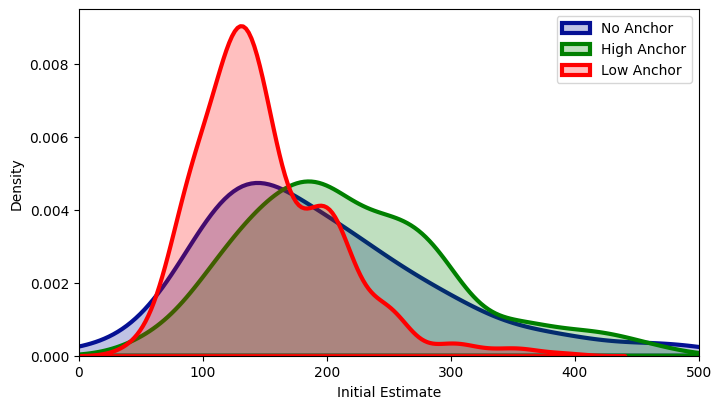

In [29]:
df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
df_old = df_old.dropna(subset=['response_1'])
df_high = df.loc[(df['Condition'] == 'High') & (df.Net_type == 'Network')]
df_high = df_high.dropna(subset=['response_1'])
df_low = df.loc[(df['Condition'] == 'Low') & (df.Net_type == 'Network')]
df_low = df_low.dropna(subset=['response_1'])


print('Comparisons')
print('High vs 2017:',stats.mannwhitneyu(df_high.response_1, df_old.response_1))
print('Low vs 2017:',stats.mannwhitneyu(df_low.response_1, df_old.response_1))

# Remove a few outliers for plotting
df_old = df_old.loc[df_old.response_1 < 500]
df_high = df_high.loc[df_high.response_1 < 500]
df_low = df_low.loc[df_low.response_1 < 500]


# Plot a density plot with the response_1 as a percentage rather than a histogram count
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.kdeplot(df_old.response_1, shade=True, color='#051094', label='No Anchor', linewidth=3)
sns.kdeplot(df_high.response_1, shade=True, color='green', label='High Anchor', linewidth=3)
sns.kdeplot(df_low.response_1, shade=True, color='red', label='Low Anchor', linewidth=3)
ax.set_xlabel('Initial Estimate')
ax.set_ylabel('Density')
ax.set_xlim(0,500)
plt.legend()
plt.savefig('Figures/SI-Density_plot.png', dpi=300)
plt.show()



Alt Figure 3

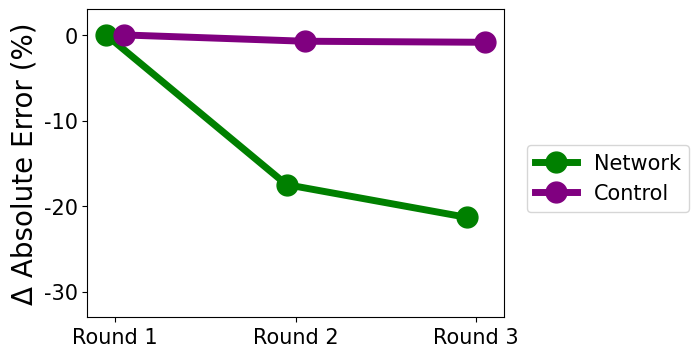

Harmful:
-16.689920508968846 -8.74563948960412
Helpful
6.071839196187245 -26.764640681361602


In [30]:
# Percentage change
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (df_net['Second_Error'] / df_net['Initial_Error']-1) * 100
df_net['R_3'] = (df_net['Final_Error'] / df_net['Initial_Error']-1) * 100

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

axs.plot([-0.05, .95, 1.95],[df_net[i].mean() for i in ['R_1', 'R_2', 'R_3']], '-o', color='green', ms = 15, lw=5, label='Network')
axs.plot([0.05, 1.05, 2.05],[df_con[i].mean() for i in ['R_1', 'R_2', 'R_3']], '-o', color='purple', ms = 15, lw=5, label='Control')

axs.set_xticks([0, 1, 2], ['Round 1', 'Round 2', 'Round 3'], fontsize=15)
axs.set_ylabel('Δ Absolute Error (%)', fontsize=20)
axs.set_ylim(-33, 3)
axs.set_yticks([-30, -20, -10, 0], ['-30', '-20', '-10','0'], fontsize=15)
fig.legend(fontsize=15,loc='center right')
plt.subplots_adjust(right=0.72)
plt.savefig('Figures/SI-Alt-Figure-3.png', dpi=300)
plt.show()

df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['Matched','group']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['Matched','group']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (df_net['Second_Error'] / df_net['Initial_Error']-1) * 100
df_net['R_3'] = (df_net['Final_Error'] / df_net['Initial_Error']-1) * 100

df_con.reset_index(inplace=True)
df_net.reset_index(inplace=True)
print('Harmful:')
print(df_con.loc[df_con.Matched == 0].R_3.mean(), df_net.loc[df_net.Matched == 0].R_3.mean())
print('Helpful')
print(df_con.loc[df_con.Matched == 1].R_3.mean(), df_net.loc[df_net.Matched == 1].R_3.mean())

# Supplemental tables

In [31]:
# Change in proximity to anchor
df_temp = df.dropna(subset=['group','Net_type','Condition','Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.groupby(['group','Net_type','Condition','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']
df_temp.to_csv('Tables/TableS2_Anchor_Distance_Table.csv')

In [32]:
# Change in proximity to truth
df_temp = df.dropna(subset=['group','Net_type','Condition', 'Initial_Error','Second_Error', 'Final_Error','Mag_Rev'])
rcs = []
for g in df_temp.group.unique():
    df_t = df_temp.loc[df_temp.group == g]
    rcs.append(round(stats.pearsonr(df_t.Initial_Error, df_t.Mag_Rev)[0],2))
df_temp = df_temp.groupby(['group','Net_type','Condition']).agg({'Initial_Error': np.median,'Second_Error': np.median,'Final_Error': np.median})
df_temp['Change in Error'] = df_temp['Final_Error'] - df_temp['Initial_Error']
df_temp['Revision Coefficient'] = rcs
df_temp.to_csv('Tables/TableS1_Truth_Distance_Table.csv')